# Capstone Project - Are coffee shops actually a good predictor of gentrification?

In [3]:
import numpy as np
import ssl
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from bs4 import BeautifulSoup
import json
import re
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import log_loss

import pylab as pl

import folium

from urllib.request import urlopen
import urllib.parse, urllib.error
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

## Introduction

Gentrification is the process whereby the character of a poor urban area is changed by wealthier people moving in, improving housing, and attracting new businesses, often displacing current inhabitants in the process. There is a popular anecdote that the gentrification of a neighborhood begins with the establishment of an expensive coffee shop. The purpose of this project is to determine whether there is any truth to the above statement through a cross-examination of venue types of Vancouver.

### Data gathering

The data used for this project has been created in 4 steps.
First, names of neighborhoods in Vancouver were scraped of the Wikipedia page listing postal codes of Canada.

In [12]:
soup = BeautifulSoup(urlopen("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V", context=ctx).read(), "html.parser")
table_contents=[]
table = soup.find('table')
for row in table.findAll('td'):
    if row.span.text=='Not assigned':
        pass
    elif row.a.get("title") !="Vancouver":
        pass
    else:
        if "/" in row.span.text:
            for i in re.split(r'\s*[,/]\s*', row.span.text[10:]):
                cell = {}
                cell['PostalCode'] = row.b.text[:3]
                if i[-1] == ")":
                    cell['Neighborhood'] = i[:-1]
                    table_contents.append(cell)
                else:
                    cell['Neighborhood'] = i
                    table_contents.append(cell)
        else:
            cell = {}
            cell['PostalCode'] = row.b.text[:3]
            cell['Neighborhood'] = row.span.text[10:-1]
            table_contents.append(cell)

vancouver=pd.DataFrame(table_contents)
vancouver
# vancouver.drop(index=0, inplace=True)
# df.reset_index(inplace=True)
# df.drop("index", axis=1, inplace=True)
# df.loc[90, "Neighborhood"] = "Champlain Park"


,PostalCode,Neighborhood
0,V6A,Strathcona
1,V6A,Chinatown
2,V6A,Downtown Eastside
3,V6B,NE Downtown
4,V6B,Gastown
5,V6B,Harbour Centre
6,V6B,International Village
7,V6B,Victory Square
8,V6B,Yaletown
9,V6C,Waterfront


Then the coordinates of each neighborhood were obtained through the Google Geocoding API.

In [14]:
vancouver["Latitude"]=None
vancouver["Longitude"]=None
serviceurl = 'https://maps.googleapis.com/maps/api/geocode/json?'
for index, row in vancouver.iterrows():
    g = {}
    g['address'] = '{}, Vancouver, British Columbia'.format(row["Neighborhood"])
    g['key'] = "************************"
    data = urllib.request.urlopen(serviceurl + urllib.parse.urlencode(g), context = ctx).read().decode()
    js = json.loads(data)
    #print(json.dumps(js, indent=4))
    vancouver.loc[index, "Latitude"] = js['results'][0]['geometry']['location']['lat']
    vancouver.loc[index, "Longitude"] = js['results'][0]['geometry']['location']['lng']

In [15]:
vancouver

,PostalCode,Neighborhood,Latitude,Longitude
0,V6A,Strathcona,49.276535,-123.08737
1,V6A,Chinatown,49.280115,-123.10582
2,V6A,Downtown Eastside,49.282997,-123.089483
3,V6B,NE Downtown,49.282729,-123.120738
4,V6B,Gastown,49.282808,-123.106688
5,V6B,Harbour Centre,49.284756,-123.111872
6,V6B,International Village,49.280133,-123.106846
7,V6B,Victory Square,49.282238,-123.110146
8,V6B,Yaletown,49.275702,-123.119906
9,V6C,Waterfront,49.286327,-123.109894


In [16]:
vancouver.to_csv(r"C:\Users\Iskender\PycharmProjects\pythonProject1\Panda\Capstone\vancouver.csv")

A script provided by IBM was used to retrieve venues in the area around each neighborhood from FourSqaures API.

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            "QGHREK13GGQP3G3ZZBIGA1YL2KITKFFOE33R3Q5XZDQBAF5M", 
            "TYC1H2O53P11IN5RX35B3T2BUCFJXIHQH1KB3WM5IXMYFHKC", 
            "20160101", 
            lat, 
            lng, 
            radius, 
            100)
            

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
  
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

vancouver_venues = getNearbyVenues(names=vancouver['Neighborhood'],
                                   latitudes=vancouver['Latitude'],
                                   longitudes=vancouver['Longitude']
                                  )



Strathcona
Chinatown
Downtown Eastside
NE Downtown
Gastown
Harbour Centre
International Village
Victory Square
Yaletown
Waterfront
Coal Harbour
Canada Place
SE West End
Davie Village
NW West End
Stanley Park
West Fairview
Granville Island
NE Shaughnessy
NW Shaughnessy
East Kitsilano
Quilchena
North Hastings-Sunrise
Central Kitsilano
Greektown
North Grandview-Woodland
NW Arbutus Ridge
NE Dunbar-Southlands
South Hastings-Sunrise
North Renfrew-Collingwood
South Shaughnessy
NW Oakridge
NE Kerrisdale
SE Arbutus Ridge
South Grandview-Woodland
NE Kensington-Cedar Cottage
West Kerrisdale
South Dunbar-Southlands
Musqueam
SE Kensington-Cedar Cottage
Victoria-Fraserview
SE Kerrisdale
SW Oakridge
West Marpole
South Renfrew-Collingwood
West Kitsilano
West Point Grey
Jericho
Killarney
NW Dunbar-Southlands
Chaldecutt
South University Endowment Lands
East Mount Pleasant
UBC
West Kensington-Cedar Cottage
NE Riley Park-Little Mountain
SE Riley Park-Little Mountain
SW Kensington-Cedar Cottage
NE Oakridge

In [19]:
vancouver_venues.to_csv(r"C:\Users\Iskender\PycharmProjects\pythonProject1\Panda\Capstone\vancouver_2016.csv")

The database of venues was encoded into dummies, then averaged to show the "concentration" of each type of venue in the neighborhood.

In [24]:
vancouver_onehot = pd.get_dummies(vancouver_venues[['Venue Category']], prefix="", prefix_sep="")
vancouver_onehot.drop("Neighborhood", axis=1, inplace=True)
vancouver_onehot.insert(0, "Neighborhood", vancouver_venues["Neighborhood"])

vancouver_grouped = vancouver_onehot.groupby('Neighborhood').mean().reset_index()

In [26]:
vancouver_onehot.to_csv(r"C:\Users\Iskender\PycharmProjects\pythonProject1\Panda\Capstone\vancouver_onehot.csv")
vancouver_grouped.to_csv(r"C:\Users\Iskender\PycharmProjects\pythonProject1\Panda\Capstone\vancouver_grouped.csv")

To find neighborhoods that are considered to have been gentrified, GENUINE (Gentrification, Urban Interventions and Equity) map created by Statistics Canada has been utilized. 

In [39]:
map_vancouver = folium.Map(location=[49.260833, -123.113889], zoom_start=10)

for lat, lng, neighborhood in zip(vancouver['Latitude'], vancouver['Longitude'], vancouver['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_vancouver)  
    
map_vancouver

In [42]:
gent_neig = """South Hastings-Sunrise
South Grandview-Woodland
Strathcona
Downtown Eastside
Chinatown
International Village
Gastown
Victory Square
Pacific Centre
SW Downtown
West Mount Pleasant
SW Kensington-Cedar Cottage
West Riley Park-Little Mountain
NE Riley Park-Little Mountain
SE Oakridge""".split("\n")

In [45]:
vancouver["gentrified"] = 0
vancouver_grouped["gentrified"] = 0

In [46]:
for index, row in vancouver.iterrows():
    if row["Neighborhood"] in gent_neig:
        vancouver.loc[index, "gentrified"] = 1

,PostalCode,Neighborhood,Latitude,Longitude,gentrified
0,V6A,Strathcona,49.276535,-123.08737,1
1,V6A,Chinatown,49.280115,-123.10582,1
2,V6A,Downtown Eastside,49.282997,-123.089483,1
3,V6B,NE Downtown,49.282729,-123.120738,0
4,V6B,Gastown,49.282808,-123.106688,1
5,V6B,Harbour Centre,49.284756,-123.111872,0
6,V6B,International Village,49.280133,-123.106846,1
7,V6B,Victory Square,49.282238,-123.110146,1
8,V6B,Yaletown,49.275702,-123.119906,0
9,V6C,Waterfront,49.286327,-123.109894,0


In [47]:
for index, row in vancouver_grouped.iterrows():
    if row["Neighborhood"] in gent_neig:
        vancouver_grouped.loc[index, "gentrified"] = 1

In [160]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Methodology

### Approach 1
#### Logistic regression with a single independent variable
This an attempt to predict the gentrification status of the neighborood based solely on the average number of coffee shops in the area. The Logistic Regression classifier of the scikit-learn machine learning library is employed with Newton's method chosen as a solver due to the usage of only a single variable and the small size of the database.

In [216]:
Y = vancouver_grouped["gentrified"]
X = vancouver_grouped[['Coffee Shop']]
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25)
LR = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,Y_train)
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [217]:
yhat_prob = LR.predict_proba(X_test)

In [218]:
jaccard_score(Y_test, yhat,pos_label=0)

0.8333333333333334

In [219]:
log_loss(Y_test, yhat_prob)

0.4630265646411481

Confusion matrix, without normalization
[[ 0  3]
 [ 0 15]]


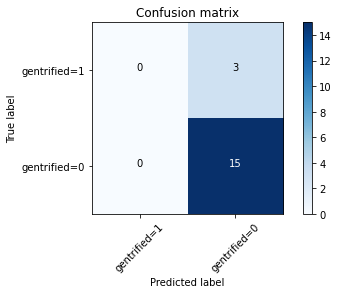

In [220]:
cnf_matrix = confusion_matrix(Y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['gentrified=1','gentrified=0'],normalize= False,  title='Confusion matrix')

The model fails to find even a single gentrified neighborhood, resulting in 3 false negatives in the 75/25 train/test split model estimation.

In [221]:
toronto_grouped = pd.read_csv("toronto_2016.csv")
toronto_grouped.drop("Unnamed: 0", axis=1, inplace=True)

In [222]:
Y2 = toronto_grouped["Gentrified"]
X2 = toronto_grouped[['Coffee Shop']]

In [223]:
yhat2 = LR.predict(X2)
yhat2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [224]:
yhat_prob2 = LR.predict_proba(X2)

In [225]:
jaccard_score(Y2, yhat2, pos_label=0)

0.74

Confusion matrix, without normalization
[[ 0 26]
 [ 0 74]]


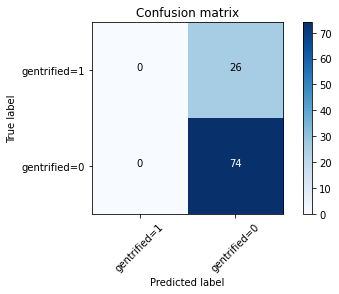

In [226]:
cnf_matrix = confusion_matrix(Y2, yhat2, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['gentrified=1','gentrified=0'],normalize= False,  title='Confusion matrix')

Using the same algorithm to test the neighborhoods of Toronto we again fail to accurately predict the gentrification status of the neighborhoods.

### Approach 2
#### Logistic regression with multiple independent variables
Similar to the above, the logistic regression model is used, but with every type of venue returned by the FourSquare API and a different solver (Library for Large Linear Classification).

In [227]:
Y = vancouver_grouped["gentrified"]
X = vancouver_grouped.iloc[:, 1:-1]
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,Y_train)
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [228]:
yhat_prob = LR.predict_proba(X_test)

In [229]:
jaccard_score(Y_test, yhat,pos_label=0)

0.7777777777777778

In [230]:
log_loss(Y_test, yhat_prob)

0.6574749004264562

Confusion matrix, without normalization
[[ 0  4]
 [ 0 14]]


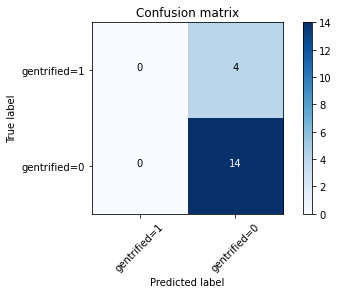

In [231]:
cnf_matrix = confusion_matrix(Y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['gentrified=1','gentrified=0'],normalize= False,  title='Confusion matrix')

Same as above, the alorithm marked all gentrified neighborhoods as false negatives. This algorithm could not be applied to the Toronto datased due to differences in venue types.

### Approach 3
#### Logistic regression with specific independent variables
In this approach the algortihm is trained using several venue types that might be indicative of gentrification.
According to a paper titled paper "Nowcasting Gentrification: Using Yelp Data to Quantify Neighborhood Change", "the opening of a Starbucks — and cafes more generally — is a leading indicator of gentrification, and is associated with an increase in local housing prices of .5%. Gentrifying neighborhoods tend to spawn a growing number of grocery stores, cafes, restaurants, and bars."

In [232]:
vancouver_grouped.columns.to_list()

['Neighborhood',
 'Accessories Store',
 'African Restaurant',
 'Airport Terminal',
 'American Restaurant',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Australian Restaurant',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Beach',
 'Beer Bar',
 'Beer Garden',
 'Belgian Restaurant',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Boxing Gym',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Station',
 'Bus Stop',
 'Business Service',
 'Butcher',
 'Cafeteria',
 'Café',
 'Cajun / Creole Restaurant',
 'Camera Store',
 'Candy Store',
 'Cantonese Restaurant',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Circus',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Comfort Food Restaurant',
 'Concert Hall',
 'Construction & Landscaping',
 'Convenience Store',
 'Cosmetics Shop',
 'Cruise Ship'

In [233]:
gentv = ['African Restaurant', 'American Restaurant', 'Asian Restaurant',  'Australian Restaurant', 'BBQ Joint', 
         'Bagel Shop', 'Bakery', 'Bar', 'Beer Bar', 'Brazilian Restaurant', 'Breakfast Spot', 'Brewery', 'Bubble Tea Shop',
         'Burger Joint', 'Burrito Place', 'Café', 'Cajun / Creole Restaurant', 'Cantonese Restaurant', 'Cheese Shop',
         'Chinese Restaurant', 'Chocolate Shop','Cocktail Bar', 'Coffee Shop', 'Comfort Food Restaurant', 'Cuban Restaurant',
         'Dive Bar', 'Donut Shop','Eastern European Restaurant','Ethiopian Restaurant', 'Falafel Restaurant','Fish & Chips Shop', 
         'French Restaurant', 'Fried Chicken Joint','Frozen Yogurt Shop','Gastropub', 'Gay Bar','German Restaurant', 
         'Greek Restaurant', 'Hawaiian Restaurant', 'Himalayan Restaurant','Ice Cream Shop', 'Indian Restaurant',
         'Irish Pub', 'Italian Restaurant', 'Japanese Curry Restaurant', 'Japanese Restaurant', 'Korean Restaurant',
         'Latin American Restaurant','Lebanese Restaurant', 'Malay Restaurant', 'Mediterranean Restaurant', 
         'Mexican Restaurant','Middle Eastern Restaurant', 'New American Restaurant','Peruvian Restaurant',
         'Peruvian Restaurant', 'Poke Place', 'Poke Place', 'Pub', 'Ramen Restaurant', 'Restaurant',
         'Salad Place', 'Sandwich Place', 'Scandinavian Restaurant','Scandinavian Restaurant', 'Shanghai Restaurant', 
         'Soup Place', 'South Indian Restaurant', 'Southern / Soul Food Restaurant', 'Spanish Restaurant', 'Sports Bar',
         'Steakhouse', 'Supermarket', 'Sushi Restaurant', 'Taco Place', 'Taiwanese Restaurant', 'Tapas Restaurant', 'Tea Room',
         'Thai Restaurant', 'Turkish Restaurant', 'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant', 'Whisky Bar',
         'Wine Bar']

In [339]:
Y = vancouver_grouped["gentrified"]
X = vancouver_grouped[vancouver_grouped.columns.intersection(gentv)]
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,Y_train)
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [340]:
yhat_prob = LR.predict_proba(X_test)

In [341]:
jaccard_score(Y_test, yhat,pos_label=0)

0.6111111111111112

In [342]:
log_loss(Y_test, yhat_prob)

0.6785149922758422

Confusion matrix, without normalization
[[ 0  7]
 [ 0 11]]


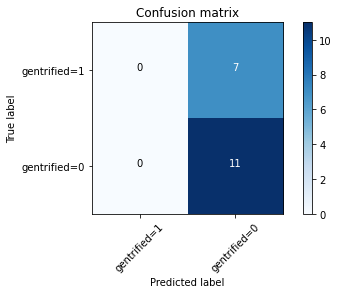

In [343]:
cnf_matrix = confusion_matrix(Y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['gentrified=1','gentrified=0'],normalize= False,  title='Confusion matrix')

Retraining the model for the Toronto dataset:

In [346]:
Y2 = toronto_grouped["Gentrified"]
X2 = toronto_grouped[toronto_grouped.columns.intersection(gentv)]

In [347]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split( X2, Y2, test_size=0.25)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train2,Y_train2)
yhat2 = LR.predict(X_test2)
yhat2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [348]:
jaccard_score(Y_test2, yhat2,pos_label=0)

0.68

In [349]:
yhat_prob2 = LR.predict_proba(X_test2)

In [350]:
log_loss(Y_test2, yhat_prob2)

0.6669398128697881

Confusion matrix, without normalization
[[ 0  8]
 [ 0 17]]


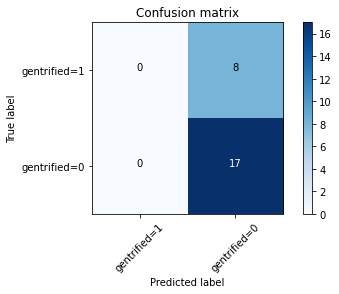

In [351]:
cnf_matrix = confusion_matrix(Y_test2, yhat2, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['gentrified=1','gentrified=0'],normalize= False,  title='Confusion matrix')

From the above it is clear that the model consistently failed to predict gentrification based solely on venue type presence in the neighborhood in a variety of cases.

### Approach 4
#### Logistic regression with random independent variables
In this approach, each venue type is plugged into the logistic regression with Newton's method solver one by one with the purpose of finding a signle venue type that might serve as a predictor of gentrification.

In [267]:
Y = vancouver_grouped["gentrified"]
for i in vancouver_grouped.iloc[:, 1:-1].columns.to_list():
    X = vancouver_grouped[[i]]
    X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25)
    LR = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,Y_train)
    yhat = LR.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
    if tp >1:
        print(i)
    else:
        print(i + ": No true positives")

Accessories Store: No true positives
African Restaurant: No true positives
Airport Terminal: No true positives
American Restaurant: No true positives
Art Gallery: No true positives
Arts & Crafts Store: No true positives
Asian Restaurant: No true positives
Athletics & Sports: No true positives
Australian Restaurant: No true positives
BBQ Joint: No true positives
Bagel Shop: No true positives
Bakery: No true positives
Bank: No true positives
Bar: No true positives
Baseball Field: No true positives
Baseball Stadium: No true positives
Beach: No true positives
Beer Bar: No true positives
Beer Garden: No true positives
Belgian Restaurant: No true positives
Board Shop: No true positives
Boat or Ferry: No true positives
Bookstore: No true positives
Boutique: No true positives
Boxing Gym: No true positives
Brazilian Restaurant: No true positives
Breakfast Spot: No true positives
Brewery: No true positives
Bubble Tea Shop: No true positives
Building: No true positives
Burger Joint: No true posit

As is apparent from the above, logistic regression using individual venues did not result in a single true positive. This has been a consisten outcome for logistic regressions using venue types in multiple various combinations. 

### Approach 5
#### Logistic regression based on venue rank within the neighborhood
In this approach, each venue type is assigned a rank based on the amount of venues of that type within the neighborhood. Neighborhoods with coffee shops in the first, second or third ranking will be highlighted using one-hot encoding, then a logistic regression will be run on the results.

In [268]:
vancouver_sum = vancouver_onehot.groupby('Neighborhood').sum().reset_index()

,Neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Beer Bar,Beer Garden,Belgian Restaurant,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise Ship,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General College & University,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Heliport,Himalayan Restaurant,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Real Estate Office,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soccer Field,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Trade School,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Bentall Centre,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,6,0,0,0,0,0,1,1,0,3,0,3,0,0,0,0,3,0,0,0,0,0,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,0,0,1,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Canada Place,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,2,1,0,1,0,0,0,0,0,0,1,3,0,0,0,0,0,0,1,0,1,0,5,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,7,3,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,

In [269]:
vancouver_sum["gentrified"] = vancouver_grouped["gentrified"]

In [380]:
vancouver_ranked = pd.DataFrame(columns =["Neighborhood", "Most popular venue", "2nd most popular venue", "3rd most popular venue"])
vancouver_ranked["Neighborhood"] = vancouver_sum["Neighborhood"]

In [381]:
for index, row in vancouver_sum.iloc[:, :-1].iterrows():
    lov = sorted(vancouver_sum.iloc[:, 1:-1].loc[index].to_list(), reverse=True)
    for i in vancouver_sum.iloc[:, 1:-1].columns.to_list():
        if vancouver_sum.iloc[:, 1:-1].loc[index, i] == lov[0]:
            vancouver_ranked.loc[index, "Most popular venue"] = i
        elif vancouver_sum.iloc[:, 1:-1].loc[index, i] == lov[1]:
            vancouver_ranked.loc[index, "2nd most popular venue"] = i
        elif vancouver_sum.iloc[:, 1:-1].loc[index, i] == lov[2]:
            vancouver_ranked.loc[index, "3rd most popular venue"] = i
vancouver_ranked

,Neighborhood,Most popular venue,2nd most popular venue,3rd most popular venue
0,Bentall Centre,Hotel,Café,Restaurant
1,Canada Place,Hotel,Boat or Ferry,Coffee Shop
2,Central Kitsilano,Coffee Shop,Park,Café
3,Chaldecutt,Sports Club,NaN,NaN
4,Chinatown,Coffee Shop,Café,Sandwich Place
5,Coal Harbour,Hotel,American Restaurant,Seafood Restaurant
6,Davie Village,Sushi Restaurant,Gay Bar,NaN
7,Downtown Eastside,Coffee Shop,NaN,Restaurant
8,East Fairview,Coffee Shop,Park,Vietnamese Restaurant
9,East Kitsilano,Coffee Shop,Park,Café


In [373]:
for index, row in vancouver_ranked.iterrows():
    if row["Most popular venue"] == "Coffee Shop" or row["2nd most popular venue"] == "Coffee Shop" or row["3rd most popular venue"] == "Coffee Shop":
        vancouver_ranked.loc[index, "coffee shop"] = 1
    else:
        vancouver_ranked.loc[index, "coffee shop"] = 0
vancouver_ranked["Gentrified"] = vancouver_sum["gentrified"]

In [374]:
vancouver_ranked

,Neighborhood,Most popular venue,2nd most popular venue,3rd most popular venue,coffee shop,Gentrified
0,Bentall Centre,Hotel,Café,Restaurant,0.0,0
1,Canada Place,Hotel,Boat or Ferry,Coffee Shop,1.0,0
2,Central Kitsilano,Coffee Shop,Park,Café,1.0,0
3,Chaldecutt,Sports Club,NaN,NaN,0.0,0
4,Chinatown,Coffee Shop,Café,Sandwich Place,1.0,1
5,Coal Harbour,Hotel,American Restaurant,Seafood Restaurant,0.0,0
6,Davie Village,Sushi Restaurant,Gay Bar,NaN,0.0,0
7,Downtown Eastside,Coffee Shop,NaN,Restaurant,1.0,1
8,East Fairview,Coffee Shop,Park,Vietnamese Restaurant,1.0,0
9,East Kitsilano,Coffee Shop,Park,Café,1.0,0


In [375]:
Y = vancouver_ranked["Gentrified"]
X = vancouver_ranked[["coffee shop"]]
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,Y_train)
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [376]:
yhat_prob = LR.predict_proba(X_test)
jaccard_score(Y_test, yhat,pos_label=0)

0.7777777777777778

In [377]:
log_loss(Y_test, yhat_prob)

0.6595717438179588

Confusion matrix, without normalization
[[ 0  4]
 [ 0 14]]


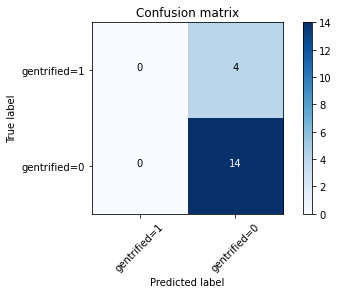

In [378]:
cnf_matrix = confusion_matrix(Y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['gentrified=1','gentrified=0'],normalize= False,  title='Confusion matrix')

The results are the same as before.

In [382]:
for index, row in vancouver_ranked.iterrows():
    if row["Most popular venue"] == "Coffee Shop" or row["2nd most popular venue"] == "Coffee Shop":
        vancouver_ranked.loc[index, "coffee shop"] = 1
    else:
        vancouver_ranked.loc[index, "coffee shop"] = 0
vancouver_ranked["Gentrified"] = vancouver_sum["gentrified"]

In [383]:
Y = vancouver_ranked["Gentrified"]
X = vancouver_ranked[["coffee shop"]]
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,Y_train)
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Confusion matrix, without normalization
[[ 0  7]
 [ 0 11]]


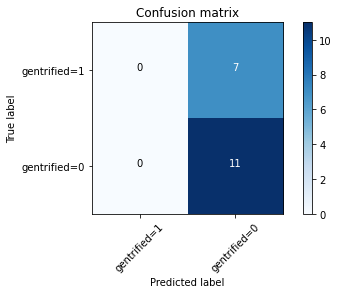

In [384]:
cnf_matrix = confusion_matrix(Y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['gentrified=1','gentrified=0'],normalize= False,  title='Confusion matrix')

 ## Results and Discussion

While this analysis failed to show a correlation between certain venue types and gentrification through logistic regression, certain caveats to these results need to be considered:
1. The dataset is extremely limited. The neighborhoods examined do not constitute the entirety of Vancouver.
2. The gentrification status is based on a single type of measurement. Ideally, in an analysis such as this it would be desirable to examine the correlation between the factors contributing to gentrification (particularly property prices), but due to difficulty in obtaining accurate data and the limited scope of the project, the analysis was performed using information on gentrification of Vancouver provided as is.
3. The data on venue types obtained from FourSquares API does not discriminate between types of venues. "Coffee shops" could include anything from local small businesses to Starbucks. There is also no guarantee that the list of venues if comprehensive.
4. The data is from a single time frame. Information on the change in number of certain venue types would perhaps better serve the purpose.

## Conclusion

In this particular study the obvious conclusion is that there is no direct link between coffee shops (or indeed other venue types) and gentrification, however, considering the caveats discussed above and the limited scope of this analysis, further research is necessary before any conclusive statements could be made. While it is true that in a variety of appraoches the logistic regression failed to identify even a single gentrified neighborhood, it cannot be stated with confidence that is there is no link at all between recreation locations and gentrification. At this point one can only conclude that the number of venues of certain types at any one time is not a good indicator of gentrification.